# GenVeg Main Script
GenVeg is a generalized vegetation growth model that simulates growth due to
photosynthesis as well as processes that control vegetation distribution such
as mortality, senescence, dispersal, and colonization. The model utilizes a 
mixture of existing and new landlab components to setup the model, simulates
relevant vegetation community dynamics with the local environment, and analyzes
results of the simulation. 

## Main model control set up
### Import components

In [1]:
import numpy as np, pandas as pd
import os, tempfile
from pathlib import Path
from datetime import date
from matplotlib.pyplot import title, show, figure, plot, subplot, xlabel, ylabel
from landlab import RasterModelGrid, imshow_grid, load_params
from landlab.data_record import DataRecord
from landlab.components.genveg import VegParams, GenVeg
from landlab.io.netcdf import write_netcdf, read_netcdf
from scipy.io import netcdf_file

### Define time controls

In [2]:
sim_start_date = np.datetime64('2010-01-01')
tot_sim_len_y = 30
veg_time_step_d = 1
env_time_step_d = 1
dt=np.timedelta64(min([veg_time_step_d,env_time_step_d]),'D')
run_length_d=365

### Define filenames for input files
##### *Note should be located in same folder as this .ipynb

In [3]:
VegInputFile = 'GenVeg_Example_Simulation.xlsx'

### Read in parameter and data input files
Identify model processes to be included so all required parameters are defined and calculated

In [4]:
inp_file=Path(VegInputFile).absolute()
VegParams(fpath=inp_file,processes=['plantsize'])
#VegParams(processes=['plantsize','dispersal','colonization','storage','mortality'])
vegparams=load_params('veg_params.yml')
print(vegparams)


{'Corn': {'duration_params': {'growing_season_end': 243, 'growing_season_start': 121, 'senescence_start': 228}, 'grow_params': {'glucose_requirement': [1.444, 1.513, 1.463], 'k_light_extinct': 0.51, 'light_half_sat': 100, 'p_max': 0.0372, 'plant_part_min': [0.01, 0.1, 0.5], 'respiration_coefficient': [0.015, 0.015, 0.03], 'root_to_leaf_coeffs': [0.031, 0.951, 0], 'root_to_stem_coeffs': [-0.107, 1.098, 0.0216]}, 'plant_factors': {'angio_gymno': 'angiosperm', 'duration': 'annual', 'growth_form': 'single_stem', 'growth_habit': 'graminoid', 'leaf_retention': 'deciduous', 'monocot_dicot': 'monocot', 'p_type': 'C4', 'shape': 'erect', 'species': 'Corn'}, 'size_params': {'max_height_stem': 1.0, 'max_n_stems': 3.0, 'max_plant_density': 34.0, 'total_cs_area_stems': 0.231}}, 'Wheat': {'duration_params': {'growing_season_end': 305, 'growing_season_start': 144, 'senescence_start': 273}, 'grow_params': {'glucose_requirement': [1.444, 1.513, 1.463], 'k_light_extinct': 0.48, 'light_half_sat': 100, 'p_

### Set up model grid using landlab RasterModelGrid functions

- Create the model grid
- Initialize live vegetation biomass and plant functional type
- Initialize the air temperature driver across the grid

##### **Note variable names should be consistent with landlab standards

In [5]:
#Create grid 10x10 node grid with 2 m node spacing and xy of origin in lat long roughly corresponding to Island Beach State Park
pg = RasterModelGrid((6, 6), 2.0, xy_of_reference=(-74.08,39.79))
pg.axis_units = ('m', 'm')

meantemp=[-0.20,  0.87,  4.40,  9.81,  15.36,  20.64,  23.86,  23.33, 19.95, 13.80,  7.85,  2.77, 11.93]
dailyTotGlobRad=[22.3, 26.8, 32.2, 37.1, 40.0, 40.9, 40.4, 38.2, 33.9, 28.5, 23.3, 21.0]
NJ_avg_par=[36.38, 52.39, 70.82, 92.88, 105.00, 116.38, 118.75, 103.21, 84.41, 59.15, 42.18, 31.98, 76.22]                
#Initialize with a random mean air temperture 
_ = pg.add_field('air__temperature_C', meantemp[0]*np.ones(pg.number_of_cells), at='cell', units='C' )
_ = pg.add_field('radiation__par_tot', NJ_avg_par[0]*np.ones(pg.number_of_cells), at='cell', units='W/m^2')


Now we initialize plants. We can do this in multiple ways. Here we are going to seed two species in a grid with 1/2 occupied by Corn, 1/2 by wheat, at single and double planting densities, respectively

In [6]:
#Initialize plant functional type as burial tolerant stabilizer or dune builder and randomly place on grid
plant_species_init=['Corn','Wheat']
plant_list_1=['Corn','null','null','null']
plant_list_2=['null','null','Wheat','null']
plant_list_3=['Corn','Corn','null','null']
plant_list_4=['null','null','Wheat','Wheat']
plant_lists=[plant_list_1,plant_list_2,plant_list_3, plant_list_4]
plants_on_grid=[]
length_field_part=pg.number_of_cells/4
for plant_list in plant_lists:
    for i in range(int(length_field_part)):
        #if plants_on_grid.isempty
        plants_on_grid.append(plant_list)

_ = pg.add_field('vegetation__plant_species',plants_on_grid, at='cell', clobber=True)

#occupied_ids=np.where(pg.at_cell['vegetation__plant_species']=='BTS')

pidval=0
plants=pd.DataFrame(columns=['pid','species','cell_index'])
for cell in range(pg.number_of_cells):
    cell_index=cell
    cell_plants=pg['cell']['vegetation__plant_species'][cell]
    for plant in cell_plants:
        species=plant
        newrow=[pidval,species,cell_index]
        plants.loc[pidval]=newrow
        pidval += 1

pid=plants.pid.loc[plants['species']=='BTS'].to_numpy(int)
total_biomass=np.random.rand(pid.shape[0])
total_biomass2=np.random.rand(6)

species_set=np.vstack((pid,total_biomass))
species_set2=np.vstack((total_biomass2,total_biomass2))
species_set=np.transpose(species_set)
species_set2=np.transpose(species_set2)
biomass=np.concatenate((species_set,species_set2), axis=0)
print(biomass)
biomass=np.transpose(biomass)
print(biomass)

### Plot grid with plant distribution and initial biomass

Use RasterModelGrid plot functions to visualize initial model grid

#### Vegetation type 
- 0=Bare
- 1=Annual
- 2=Herbaceous Perennial 
- 3=Woody Perennial

### Define model time variables
Determine basic model timestep and counter for model loop

sim_end = date(sim_start_date.year+tot_sim_len_y,sim_start_date.month,sim_start_date.day)
dt = min([veg_time_step_d,env_time_step_d])
#data['dt']=dt
day_freq = str(dt)+'D'
date_counter = pd.date_range(start=sim_start_date,end=sim_end,freq=day_freq).strftime('%Y-%m-%d').tolist()
step_counter=range(len(date_counter))
model_counter=tuple(zip(step_counter,date_counter))

Initialize crops PlantGrowth class with veg_params from Excel file

In [7]:
croprun=GenVeg(pg,dt,sim_start_date,vegparams)

d:\python\landlab\landlab\plot\imshow.py:288: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("pink").copy()
  cmap.set_bad(alpha=0.0)
d:\python\landlab\landlab\plot\imshow.py:328: MatplotlibDeprecationWarning: The 'norm' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb = plt.colorbar(norm=norm, shrink=shrink)


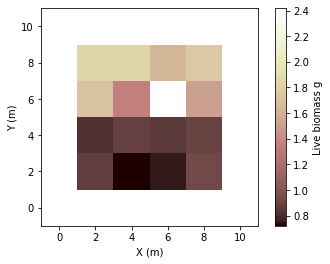

In [8]:
imshow_grid(pg, 'vegetation__total_biomass', at='cell', colorbar_label='Live biomass g')

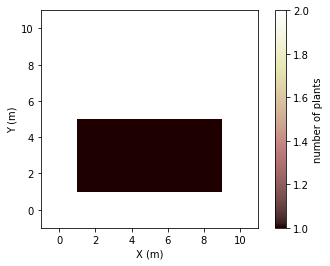

In [9]:
imshow_grid(pg, 'vegetation__n_plants', at='cell', colorbar_label='number of plants')

## Main model loop script
This is the main model loop that controls the simulation that
- Advances model time 
- Updates environmental variables
- Simulates changes to vegetation communities
- Stores outputs

In [10]:
#This runs through fine for day 1 of growing season. We need to decide how to track current day
temp_dir = tempfile.mkdtemp()
os.chdir(temp_dir)
j=-1
for i in range(run_length_d):
    #update temp attribute on grid
    if (i/30).is_integer():
        pg.at_cell['air__temperature_C']= meantemp[j+1]*np.ones(pg.number_of_cells)
        pg.at_cell['radiation__par_tot']= NJ_avg_par[j+1]*np.ones(pg.number_of_cells)
        j+=1
    #update solar radiation on grid
    croprun.run_one_step()
    
    if (i/7).is_integer():
        croprun.save_output()
        croprun.get_plant_output('Corn')
        write_netcdf("crop.nc",pg, format="NETCDF3_64BIT",append=True, time=(croprun.current_day-croprun.start_date).astype(float)-1, names=['vegetation__total_biomass', 'vegetation__n_plants'])

          #if this is a save timestep, save grid object to netcdf
    #create record method in croprun that uses datarecord to save PlantGrowth object and grid at time
    #if i in savetime:
    #    croprun.record()

IndexError: list index out of range

In [ ]:
print(vegparams)

In [ ]:
output=croprun.get_plant_output()

grid = netcdf_file('crop.nc', 'r')
print(grid.__dict__)

timegrid=grid.variables['t']
timegrid[:]

vegbio=grid.variables['vegetation__total_biomass']
vegbio.shape

vegbio[10,:,:]

In [ ]:
output.index.unique(level=2)

In [ ]:
output.loc[:, 'Corn',6] #timestep,species,plant number in []

output.loc[21.0]

In [ ]:
biomass = output["vegetation__root_biomass"].values
display(biomass)


grid.close()

In [ ]:
print((0/28).is_integer())

In [ ]:
i=0
print((i/30).is_integer())